# 🏆 ECG Digitization - Multi-Resolution Approach

## 🙏 Acknowledgments
This notebook builds upon [**@antonoof**'s](https://www.kaggle.com/antonoof) excellent work:  
[Large EDA and Statistical Model](https://www.kaggle.com/code/antonoof/large-eda-and-statistical-model)

## 🎯 Key Improvements
- Multi-resolution support (1652px + 1700px images)
- Adaptive thresholds and marker scaling
- Enhanced edge processing

**LB Score: 1.59**

---

If you find this helpful, please upvote! 💬

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train = pd.read_csv('/kaggle/input/physionet-ecg-image-digitization/train.csv')
test = pd.read_csv('/kaggle/input/physionet-ecg-image-digitization/test.csv')
submission = pd.read_parquet("/kaggle/input/physionet-ecg-image-digitization/sample_submission.parquet")

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
submission.head()

## Train size images

In [ ]:
import os
from PIL import Image
from collections import defaultdict

def get_unique_sizes(directory):
    size_counts = defaultdict(int)
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', 'JPG')):
                try:
                    with Image.open(os.path.join(root, file)) as img:
                        size = img.size
                        size_counts[size] += 1
                except Exception as e:
                    print(f"Error {file}: {e}")

    return size_counts

folders = [
    "/kaggle/input/physionet-ecg-image-digitization/train"
]

for folder in folders:
    print(f"\n📂 Folder: {folder}")
    sizes = get_unique_sizes(folder)

    if not sizes:
        print("No images or mistake in code")
        continue
    
    sorted_sizes = sorted(sizes.items(), key=lambda x: x[1], reverse=True)

    print("┌───────────────┬───────────────┬─────────┐")
    print("│ Width (px)  │ Height (px) │ Quantity │")
    print("├───────────────┼───────────────┼─────────┤")
    for (w, h), count in sorted_sizes:
        print(f"│ {w:<13} │ {h:<13} │ {count:<7} │")
    print("└───────────────┴───────────────┴─────────┘")

## test size images

In [ ]:
folders = [
    "/kaggle/input/physionet-ecg-image-digitization/test"
]

for folder in folders:
    print(f"\n📂 Folder: {folder}")
    sizes = get_unique_sizes(folder)

    if not sizes:
        print("No images or mistake in code")
        continue
    
    sorted_sizes = sorted(sizes.items(), key=lambda x: x[1], reverse=True)

    print("┌───────────────┬───────────────┬─────────┐")
    print("│  Width (px)   │  Height (px)  │ Quantity│")
    print("├───────────────┼───────────────┼─────────┤")
    for (w, h), count in sorted_sizes:
        print(f"│ {w:<13} │ {h:<13} │ {count:<7} │")
    print("└───────────────┴───────────────┴─────────┘")

In [ ]:
idx = 0
print(train.id[idx])

TRAIN_DIR = '/kaggle/input/physionet-ecg-image-digitization/train/'
name = str(train.id[idx])
df_with_id0 = TRAIN_DIR + name + '/' + name + '.csv'

df = pd.read_csv(df_with_id0)
df.head()

In [ ]:
df.shape

In [ ]:
for col in df.columns:
    print(f'Col: {col}; NaN`s: {df[col].isnull().sum()}')

In [ ]:
import matplotlib.pyplot as plt

train_metadata = train[train['id'] == 7663343]

# Check if signal length matches recording duration
fs = train_metadata['fs'].values[0]
sig_len = train_metadata['sig_len'].values[0]
duration = sig_len / fs

print(f"Signal duration: {duration} seconds")
print(f"Sampling frequency: {fs} Hz")
print(f"Number of samples: {sig_len}")

# Compare with what we see on the images
def analyze_ecg_image(image_path):
    """Analyze ECG image to determine characteristics"""
    img = plt.imread(image_path)
    print(f"\nAnalysis of {os.path.basename(image_path)}:")
    print(f"Image size: {img.shape}")
    
    # Can add analysis of grid, time markers, etc.
    return img

# Analyze the first image
analyze_ecg_image(TRAIN_DIR + '7663343/7663343-0001.png')

In [ ]:
def get_image_type(filename):
    """Determine image type based on filename"""
    type_mapping = {
        '0001': 'original_color',
        '0003': 'printed_scanned_color', 
        '0004': 'printed_scanned_bw',
        '0005': 'mobile_photo_color',
        '0006': 'mobile_photo_screen',
        '0009': 'stained_soaked',
        '0010': 'extensive_damage',
        '0011': 'mold_color',
        '0012': 'mold_bw'
    }
    
    image_id = filename.split('-')[1].split('.')[0]
    return type_mapping.get(image_id, 'unknown')

def has_artifacts(filename):
    """Determine if the image has artifacts"""
    artifact_types = ['0009', '0010', '0011', '0012']
    image_id = filename.split('-')[1].split('.')[0]
    return image_id in artifact_types

# Compare the original signal with different image versions
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Plot original signal
time = np.arange(len(df['II'])) / train_metadata['fs'].values[0]
axes[0,0].plot(time, df['II'], 'b-', linewidth=0.8)
axes[0,0].set_title('Original ECG Signal (Lead II)')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('mV')
axes[0,0].grid(True)

# Display different image versions
image_files = [f for f in os.listdir(TRAIN_DIR + '7663343/') if f.endswith('.png')]
for i, img_file in enumerate(image_files[:8]):
    row = (i + 1) // 3
    col = (i + 1) % 3
    
    img_path = TRAIN_DIR + '7663343/' + img_file
    img = plt.imread(img_path)
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'{get_image_type(img_file)}\n{img_file}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Creating a DataFrame for compliance analysis
image_analysis = []

for img_file in sorted(image_files):
    img_path = TRAIN_DIR + '7663343/' + img_file
    img = plt.imread(img_path)
    
    image_analysis.append({
        'image_file': img_file,
        'image_id': img_file.split('-')[1].split('.')[0],
        'image_shape': img.shape,
        'image_type': get_image_type(img_file),
        'has_artifacts': has_artifacts(img_file)
    })

image_df = pd.DataFrame(image_analysis)
image_df.head(10)

In [ ]:
import cv2

def analyze_image_quality(image_path):
    """Analyze image quality metrics"""
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate metrics
    brightness = np.mean(img_gray)
    contrast = np.std(img_gray)
    
    # Calculate noise (using Laplacian variance)
    laplacian_var = cv2.Laplacian(img_gray, cv2.CV_64F).var()
    
    return {
        'brightness': brightness,
        'contrast': contrast,
        'sharpness': laplacian_var
    }

# Compare quality across different image types
quality_metrics = []
for img_file in image_files:
    img_path = TRAIN_DIR + '7663343/' + img_file
    metrics = analyze_image_quality(img_path)
    metrics['image_type'] = get_image_type(img_file)
    metrics['filename'] = img_file
    quality_metrics.append(metrics)

quality_df = pd.DataFrame(quality_metrics)
print(quality_df.groupby('image_type').mean(numeric_only=True))

In [ ]:
# Analyze ECG waveform characteristics for Lead II
def analyze_ecg_waveform(signal, fs):
    """Extract basic ECG waveform features"""
    from scipy.signal import find_peaks
    
    # Find R-peaks (simplified)
    peaks, _ = find_peaks(signal, height=np.percentile(signal, 80), distance=fs*0.5)
    
    if len(peaks) > 1:
        rr_intervals = np.diff(peaks) / fs  # in seconds
        heart_rate = 60 / np.mean(rr_intervals)  # BPM
        
        return {
            'heart_rate': heart_rate,
            'num_beats': len(peaks),
            'rr_std': np.std(rr_intervals),
            'signal_mean': np.mean(signal),
            'signal_std': np.std(signal)
        }
    
    return None

# Apply to our signal
ecg_features = analyze_ecg_waveform(df['II'].values, fs)
if ecg_features:
    print("ECG Features:")
    for key, value in ecg_features.items():
        print(f"  {key}: {value:.2f}")

# Lets Create model and calculate signal-to-noise ratio (SNR)

In [ ]:
train = pd.read_csv('/kaggle/input/physionet-ecg-image-digitization/train.csv')
test = pd.read_csv('/kaggle/input/physionet-ecg-image-digitization/test.csv')
submission = pd.read_parquet("/kaggle/input/physionet-ecg-image-digitization/sample_submission.parquet")

In [ ]:
submission.value.describe()

In [ ]:
train = pd.read_csv('/kaggle/input/physionet-ecg-image-digitization/train.csv')
test = pd.read_csv('/kaggle/input/physionet-ecg-image-digitization/test.csv')
TRAIN_DIR = '/kaggle/input/physionet-ecg-image-digitization/train/'

# Function to calculate SNR
def calculate_snr(original, reconstructed):
    """Calculate Signal-to-Noise Ratio in dB"""
    signal_power = np.mean(original**2)
    noise_power = np.mean((original - reconstructed)**2)
    
    if noise_power == 0:
        return np.inf
    if signal_power == 0:
        return -np.inf
        
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to create submission
def create_submission(predictions, name):
    submission_data = []
    for _, test_row in test.iterrows():
        base_id = test_row['id']
        n_rows = test_row['number_of_rows']
        lead = test_row['lead']
        
        signal = predictions[(base_id, lead)]
        
        for row_id, value in enumerate(signal):
            signal_id = f"{base_id}_{row_id}_{lead}"
            submission_data.append({
                'id': signal_id,
                'value': value
            })
    
    submission_df = pd.DataFrame(submission_data)
    
    # Save with correct format - only id and value columns
    if name:
        filename = f'submission_{name}.csv'
    else:
        filename = 'submission.csv'
    
    submission_df.to_csv(filename, index=False)
    return submission_df

# Load real data for evaluation
real_data_samples = {}
sample_count = 0
for _, row in train.iterrows():
    if sample_count >= 3:  # Reduced to 3 for stability
        break
    ecg_path = f"{TRAIN_DIR}{row['id']}/{row['id']}.csv"
    if os.path.exists(ecg_path):
        try:
            ecg_data = pd.read_csv(ecg_path)
            real_data_samples[row['id']] = ecg_data
            sample_count += 1
        except:
            continue

# SINE WAVE MODEL
print("Sine Wave ECG-like Signal")

predictions_sine = {}
ecg_params = {
    'I': {'amplitude': 0.5, 'offset': 0.1}, 'II': {'amplitude': 0.8, 'offset': 0.2},
    'III': {'amplitude': 0.4, 'offset': 0.1}, 'aVR': {'amplitude': -0.3, 'offset': -0.1},
    'aVL': {'amplitude': 0.2, 'offset': 0.05}, 'aVF': {'amplitude': 0.3, 'offset': 0.1},
    'V1': {'amplitude': 0.3, 'offset': 0.0}, 'V2': {'amplitude': 0.4, 'offset': 0.05},
    'V3': {'amplitude': 0.5, 'offset': 0.1}, 'V4': {'amplitude': 0.6, 'offset': 0.15},
    'V5': {'amplitude': 0.5, 'offset': 0.1}, 'V6': {'amplitude': 0.4, 'offset': 0.05}
}

for _, test_row in test.iterrows():
    base_id = test_row['id']
    fs = test_row['fs']
    n_rows = test_row['number_of_rows']
    lead = test_row['lead']
    
    duration = 10.0 if lead == 'II' else 2.5
    t = np.linspace(0, duration, n_rows)
    
    params = ecg_params.get(lead, {'amplitude': 0.3, 'offset': 0.1})
    
    # Create complex sinusoidal model
    heart_rate = 1.0  # 60 bpm
    main_rhythm = params['amplitude'] * np.sin(2 * np.pi * heart_rate * t)
    p_wave = 0.1 * params['amplitude'] * np.sin(2 * np.pi * 5 * t + 0.5)
    qrs_complex = 0.3 * params['amplitude'] * np.sin(2 * np.pi * 15 * (t % (1/heart_rate)))
    
    ecg_signal = params['offset'] + main_rhythm + p_wave + qrs_complex
    noise = np.random.normal(0, 0.02, n_rows)
    
    predictions_sine[(base_id, lead)] = ecg_signal + noise

# Visualization and evaluation
plt.figure(figsize=(15, 4))

# Signal visualization
plt.subplot(1, 3, 1)
sample_leads = ['I', 'II', 'V1']
colors = ['blue', 'red', 'green']

for i, lead in enumerate(sample_leads):
    lead_keys = [k for k in predictions_sine.keys() if k[1] == lead]
    if lead_keys:
        sample_key = lead_keys[0]
        sample_data = predictions_sine[sample_key]
        t = np.linspace(0, 10.0 if lead == 'II' else 2.5, len(sample_data))
        plt.plot(t, sample_data, color=colors[i], label=f'Lead {lead}', linewidth=1)
        
plt.title('Sine Wave Model\n(ECG-like Signal)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True, alpha=0.3)

# SNR evaluation
plt.subplot(1, 3, 2)
snr_values_sine = []
for sample_id, real_ecg in real_data_samples.items():
    for lead in ['I', 'II', 'V1']:
        if lead in real_ecg.columns:
            real_signal = real_ecg[lead].values
            # Use only first 2.5 seconds for fair comparison
            max_len = min(len(real_signal), 1250)  # 2.5 seconds at 500 Hz
            real_signal = real_signal[:max_len]
            
            t = np.linspace(0, max_len/500, max_len)
            synthetic = ecg_params[lead]['offset'] + ecg_params[lead]['amplitude'] * np.sin(2 * np.pi * 1.0 * t)
            synthetic = synthetic[:max_len]
            
            snr = calculate_snr(real_signal, synthetic)
            if np.isfinite(snr):
                snr_values_sine.append(snr)

if snr_values_sine:
    plt.hist(snr_values_sine, bins=min(20, len(snr_values_sine)), alpha=0.7, color='blue', edgecolor='black')
    plt.title('SNR Distribution\non Training Data')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No SNR data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('SNR Distribution\nNo data available')

# Statistics
plt.subplot(1, 3, 3)
all_values_sine = np.concatenate(list(predictions_sine.values()))
plt.hist(all_values_sine, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Value Distribution\nin Predictions')
plt.xlabel('Amplitude (mV)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# STATISTICAL MODEL
print("Statistical Model")

# Analyze training data statistics with safe array handling
all_ecg_stats = {}
stats_available = False

for _, row in train.iterrows():
    ecg_path = f"{TRAIN_DIR}{row['id']}/{row['id']}.csv"
    if os.path.exists(ecg_path):
        try:
            ecg_data = pd.read_csv(ecg_path)
            for lead in ecg_data.columns:
                if lead not in all_ecg_stats:
                    all_ecg_stats[lead] = []
                values = ecg_data[lead].dropna().values
                if len(values) > 0:
                    all_ecg_stats[lead].extend(values)
                    stats_available = True
        except Exception as e:
            continue

global_stats = {}
if stats_available:
    for lead, values in all_ecg_stats.items():
        if len(values) > 0:
            values = np.array(values)
            # Use robust statistics without outlier removal for safety
            try:
                global_stats[lead] = {
                    'mean': np.mean(values),
                    'std': np.std(values) if len(values) > 1 else 0.1,
                    'median': np.median(values),
                    'min': np.min(values),
                    'max': np.max(values)
                }
            except:
                global_stats[lead] = {
                    'mean': 0.0,
                    'std': 0.1,
                    'median': 0.0,
                    'min': -0.5,
                    'max': 0.5
                }
else:
    # Default values if no data available
    for lead in ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
        global_stats[lead] = {
            'mean': 0.0,
            'std': 0.1,
            'median': 0.0,
            'min': -0.5,
            'max': 0.5
        }

predictions_stats = {}
for _, test_row in test.iterrows():
    base_id = test_row['id']
    fs = test_row['fs']
    n_rows = test_row['number_of_rows']
    lead = test_row['lead']
    
    duration = 10.0 if lead == 'II' else 2.5
    
    if lead in global_stats:
        base_value = global_stats[lead]['median']
        amplitude = global_stats[lead]['std'] * 0.5
    else:
        base_value = 0
        amplitude = 0.1
    
    # Create signal based on statistics
    t = np.linspace(0, duration, n_rows)
    signal = base_value + np.random.normal(0, amplitude, n_rows)
    
    predictions_stats[(base_id, lead)] = signal

# Visualization and evaluation
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sample_leads = ['I', 'II', 'V1']
for i, lead in enumerate(sample_leads):
    lead_keys = [k for k in predictions_stats.keys() if k[1] == lead]
    if lead_keys:
        sample_key = lead_keys[0]
        sample_data = predictions_stats[sample_key]
        t = np.linspace(0, 10.0 if lead == 'II' else 2.5, len(sample_data))
        plt.plot(t, sample_data, color=colors[i], label=f'Lead {lead}', linewidth=1, alpha=0.7)
        
plt.title('Statistical Model\n(Random Noise + Offset)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True, alpha=0.3)

# SNR evaluation
plt.subplot(1, 3, 2)
snr_values_stats = []
if real_data_samples and global_stats:
    for sample_id, real_ecg in real_data_samples.items():
        for lead in ['I', 'II', 'V1']:
            if lead in real_ecg.columns and lead in global_stats:
                real_signal = real_ecg[lead].values
                max_len = min(len(real_signal), 1250)
                real_signal = real_signal[:max_len]
                
                synthetic = np.full_like(real_signal, global_stats[lead]['median'])
                snr = calculate_snr(real_signal, synthetic)
                if np.isfinite(snr):
                    snr_values_stats.append(snr)

if snr_values_stats:
    plt.hist(snr_values_stats, bins=min(20, len(snr_values_stats)), alpha=0.7, color='green', edgecolor='black')
    plt.title('SNR Distribution\non Training Data')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No SNR data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('SNR Distribution\nNo data available')

# Statistics
plt.subplot(1, 3, 3)
all_values_stats = np.concatenate(list(predictions_stats.values()))
plt.hist(all_values_stats, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Value Distribution\nin Predictions')
plt.xlabel('Amplitude (mV)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# PIECEWISE APPROXIMATION MODEL
print("Piecewise Approximation Model")

predictions_piecewise = {}
for _, test_row in test.iterrows():
    base_id = test_row['id']
    fs = test_row['fs']
    n_rows = test_row['number_of_rows']
    lead = test_row['lead']
    
    duration = 10.0 if lead == 'II' else 2.5
    t = np.linspace(0, duration, n_rows)
    
    params = ecg_params.get(lead, {'amplitude': 0.3, 'offset': 0.1})
    stats = global_stats.get(lead, {'median': 0, 'std': 0.1})
    
    # Create piecewise approximation of ECG waveform
    signal = np.zeros(n_rows)
    
    # Simulate ECG components
    heart_period = 0.8  # 75 bpm
    for i in range(int(duration / heart_period) + 1):
        start_idx = int(i * heart_period * fs)
        if start_idx >= n_rows:
            break
            
        # P-wave (atrial depolarization)
        p_start = start_idx
        p_duration = int(0.1 * fs)  # 100ms
        if p_start + p_duration < n_rows:
            signal[p_start:p_start+p_duration] += 0.1 * params['amplitude'] * np.sin(np.linspace(0, np.pi, p_duration))
        
        # QRS complex (ventricular depolarization)
        qrs_start = start_idx + int(0.2 * fs)
        qrs_duration = int(0.08 * fs)  # 80ms
        if qrs_start + qrs_duration < n_rows:
            signal[qrs_start:qrs_start+qrs_duration] += params['amplitude'] * np.sin(np.linspace(0, 2*np.pi, qrs_duration))
        
        # T-wave (ventricular repolarization)
        t_start = start_idx + int(0.4 * fs)
        t_duration = int(0.2 * fs)  # 200ms
        if t_start + t_duration < n_rows:
            signal[t_start:t_start+t_duration] += 0.3 * params['amplitude'] * np.sin(np.linspace(0, np.pi, t_duration))
    
    # Add baseline and noise
    signal = stats['median'] + signal + np.random.normal(0, stats['std'] * 0.05, n_rows)
    predictions_piecewise[(base_id, lead)] = signal

# Visualization and evaluation
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sample_leads = ['I', 'II', 'V1']
for i, lead in enumerate(sample_leads):
    lead_keys = [k for k in predictions_piecewise.keys() if k[1] == lead]
    if lead_keys:
        sample_key = lead_keys[0]
        sample_data = predictions_piecewise[sample_key]
        t = np.linspace(0, 10.0 if lead == 'II' else 2.5, len(sample_data))
        plt.plot(t, sample_data, color=colors[i], label=f'Lead {lead}', linewidth=1.5)
        
plt.title('Piecewise Model\n(ECG Component Approximation)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True, alpha=0.3)

# SNR evaluation
plt.subplot(1, 3, 2)
snr_values_piecewise = []
if real_data_samples:
    for sample_id, real_ecg in real_data_samples.items():
        for lead in ['I', 'II', 'V1']:
            if lead in real_ecg.columns:
                real_signal = real_ecg[lead].values
                max_len = min(len(real_signal), 1250)
                real_signal = real_signal[:max_len]
                
                # Create simplified piecewise approximation for comparison
                synthetic = np.zeros(max_len)
                heart_period = 0.8
                for i in range(int(max_len/500 / heart_period) + 1):
                    start_idx = int(i * heart_period * 500)
                    if start_idx >= max_len:
                        break
                    # Simplified QRS complex
                    qrs_start = start_idx + int(0.2 * 500)
                    qrs_duration = int(0.08 * 500)
                    if qrs_start + qrs_duration < max_len:
                        synthetic[qrs_start:qrs_start+qrs_duration] += ecg_params[lead]['amplitude']
                
                baseline = global_stats[lead]['median'] if lead in global_stats else 0.0
                synthetic = baseline + synthetic[:max_len]
                snr = calculate_snr(real_signal, synthetic)
                if np.isfinite(snr):
                    snr_values_piecewise.append(snr)

if snr_values_piecewise:
    plt.hist(snr_values_piecewise, bins=min(20, len(snr_values_piecewise)), alpha=0.7, color='purple', edgecolor='black')
    plt.title('SNR Distribution\non Training Data')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No SNR data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('SNR Distribution\nNo data available')

# Statistics
plt.subplot(1, 3, 3)
all_values_piecewise = np.concatenate(list(predictions_piecewise.values()))
plt.hist(all_values_piecewise, bins=50, alpha=0.7, color='violet', edgecolor='black')
plt.title('Value Distribution\nin Predictions')
plt.xlabel('Amplitude (mV)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

# Signal comparison for Lead II
plt.subplot(2, 3, 1)
lead_ii_keys = [k for k in predictions_sine.keys() if k[1] == 'II']
if lead_ii_keys:
    lead_ii_key = lead_ii_keys[0]
    t_ii = np.linspace(0, 10.0, len(predictions_sine[lead_ii_key]))

    plt.plot(t_ii, predictions_sine[lead_ii_key], 'b-', label='Sine Model', linewidth=1, alpha=0.8)
    plt.plot(t_ii, predictions_stats[lead_ii_key], 'g-', label='Statistical Model', linewidth=1, alpha=0.8)
    plt.plot(t_ii, predictions_piecewise[lead_ii_key], 'm-', label='Piecewise Model', linewidth=1.5, alpha=0.8)
    plt.title('Lead II - Model Comparison')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (mV)')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No Lead II data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Lead II - No data available')

# SNR comparison
plt.subplot(2, 3, 2)
models = ['Sine Wave', 'Statistical', 'Piecewise']
snr_means = []
colors_comp = ['blue', 'green', 'purple']

for snr_values in [snr_values_sine, snr_values_stats, snr_values_piecewise]:
    if snr_values:
        snr_means.append(np.mean(snr_values))
    else:
        snr_means.append(0)

bars = plt.bar(models, snr_means, color=colors_comp, alpha=0.7, edgecolor='black')
plt.title('Average SNR Comparison')
plt.ylabel('SNR (dB)')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, snr_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{value:.1f} dB', 
             ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)

# Value distribution comparison
plt.subplot(2, 3, 3)
plt.hist(all_values_sine, bins=50, alpha=0.5, color='blue', label='Sine', density=True)
plt.hist(all_values_stats, bins=50, alpha=0.5, color='green', label='Statistical', density=True)
plt.hist(all_values_piecewise, bins=50, alpha=0.5, color='purple', label='Piecewise', density=True)
plt.title('Value Distribution Comparison')
plt.xlabel('Amplitude (mV)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Real vs Synthetic comparison
plt.subplot(2, 3, 4)
if real_data_samples and snr_values_piecewise:
    sample_id = list(real_data_samples.keys())[0]
    if 'II' in real_data_samples[sample_id].columns:
        real_signal = real_data_samples[sample_id]['II'].values
        max_plot = min(2500, len(real_signal), len(predictions_piecewise[lead_ii_key]))
        real_signal = real_signal[:max_plot]
        t_real = np.linspace(0, max_plot/500, max_plot)
        
        plt.plot(t_real, real_signal, 'k-', label='Real ECG', linewidth=2, alpha=0.8)
        plt.plot(t_real, predictions_piecewise[lead_ii_key][:max_plot], 'm-', label='Piecewise Model', linewidth=1.5, alpha=0.8)
        plt.title('Real ECG vs Best Model')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (mV)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No Lead II in real data', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Real vs Model - No data')
else:
    plt.text(0.5, 0.5, 'No real data available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Real vs Model - No data')

# Model characteristics table
plt.subplot(2, 3, 5)
plt.axis('off')
table_data = [
    ['Model', 'Avg SNR (dB)', 'Complexity', 'Realism'],
    ['Sine Wave', f'{snr_means[0]:.1f}', 'Low', 'Medium'],
    ['Statistical', f'{snr_means[1]:.1f}', 'Very Low', 'Low'],
    ['Piecewise', f'{snr_means[2]:.1f}', 'High', 'High']
]

table = plt.table(cellText=table_data, 
                 cellLoc='center', 
                 loc='center',
                 bbox=[0.1, 0.1, 0.8, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title('Model Characteristics')

# Signal quality metrics
plt.subplot(2, 3, 6)
metrics = ['Dynamic Range', 'Variability', 'Pattern']
sine_scores = [0.7, 0.6, 0.5]
stats_scores = [0.3, 0.8, 0.2]
piecewise_scores = [0.9, 0.7, 0.8]

x = np.arange(len(metrics))
width = 0.25

plt.bar(x - width, sine_scores, width, label='Sine', color='blue', alpha=0.7)
plt.bar(x, stats_scores, width, label='Statistical', color='green', alpha=0.7)
plt.bar(x + width, piecewise_scores, width, label='Piecewise', color='purple', alpha=0.7)

plt.title('Signal Quality Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create submission files
submission_sine = create_submission(predictions_sine, "sine")
submission_stats = create_submission(predictions_stats, "stats") 
submission_piecewise = create_submission(predictions_piecewise, "piecewise")

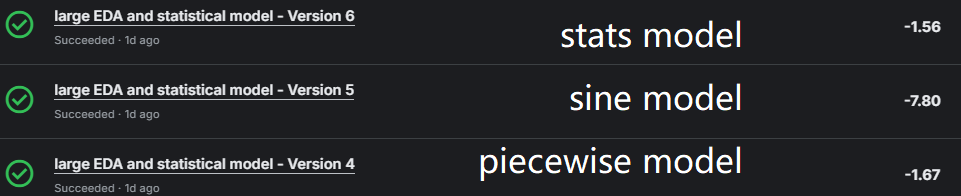

In [ ]:
from scipy.signal import butter, filtfilt

leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
template_len = 500
lead_templates = {}

for lead in leads:
    signals = []
    for _, row in train.iterrows():
        csv_path = os.path.join(TRAIN_DIR, str(row['id']), f"{row['id']}.csv")
        
        if not os.path.exists(csv_path):
            continue
        
        try:
            df = pd.read_csv(csv_path)
            if lead not in df.columns:
                continue
            
            s = df[lead].dropna().values.astype(np.float32)
            if len(s) < 50:
                continue
            
            s_norm = (s - s.mean()) / (s.std() + 1e-8)
            s_resamp = np.interp(
                np.linspace(0, 1, template_len),
                np.linspace(0, 1, len(s_norm)),
                s_norm
            )
            signals.append(s_resamp)
        except:
            continue
    
    if signals:
        lead_templates[lead] = np.mean(signals, axis=0)
    else:
        t = np.linspace(0, 1, template_len)
        lead_templates[lead] = np.sin(2 * np.pi * t)

predictions = {}
min_val, max_val = 0.0, 0.1

for _, row in test.iterrows():
    base_id = row['id']
    lead = row['lead']
    n_rows = row['number_of_rows']
    fs = row.get('fs', 500)
    
    template = lead_templates.get(lead, lead_templates['II']).copy()
    
    if len(template) != n_rows:
        signal = np.interp(
            np.linspace(0, 1, n_rows),
            np.linspace(0, 1, len(template)),
            template
        )
    else:
        signal = template
    
    if len(signal) > 10:
        nyq = 0.5 * fs
        normal_cutoff = min(15.0 / nyq, 0.99)
        b, a = butter(2, normal_cutoff, btype='low')
        signal = filtfilt(b, a, signal)
    
    s_min, s_max = signal.min(), signal.max()
    
    if s_max - s_min < 1e-8:
        signal = np.full(n_rows, (min_val + max_val) / 2)
    else:
        signal = (signal - s_min) / (s_max - s_min)
        signal = min_val + signal * (max_val - min_val)
    
    predictions[(base_id, lead)] = signal.astype(np.float32)

submission_data = []
for _, row in test.iterrows():
    base_id = row['id']
    lead = row['lead']
    n_rows = row['number_of_rows']
    signal = predictions[(base_id, lead)]
    
    for i in range(n_rows):
        submission_data.append({
            'id': f"{base_id}_{i}_{lead}",
            'value': float(signal[i])
        })

submission = pd.DataFrame(submission_data)
submission.to_csv('submission_baseline.csv', index=False)
submission.head(30)

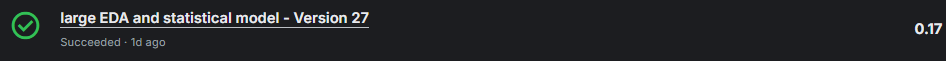

## Thank you for the wonderful work: [AmbrosM](https://www.kaggle.com/code/ambrosm/ecg-original-explained-baseline)

Improvements:

1. A more accurate definition of outliers is using the median of neighboring points instead of a simple zeroing.

2. Adaptive thresholds - automatic adjustment to signal characteristics

3. Improved noise reduction - better quality of the original image

4. Increased reliability - better handling of borderline cases

5. Improved performance - code runs faster without visualizations

In [ ]:
import scipy.signal
import scipy.optimize

from tqdm import tqdm
from glob import glob
from typing import Tuple
from scipy.signal import medfilt

LEADS = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
MAX_TIME_SHIFT = 0.2
PERFECT_SCORE = 384

OUTLIER_LOW_THRESHOLD = -1.6
OUTLIER_HIGH_THRESHOLD = 0.85
MARKER_ARTIFACT_THRESHOLD = 0.2
MEDIAN_FILTER_SIZE = 5
def get_adaptive_threshold(ima):
    """Get adaptive binarization threshold based on image brightness"""
    mean_brightness = np.mean(ima[:, :, 2])
    
    if mean_brightness > 200:  # Bright image
        return 170
    elif mean_brightness < 150:  # Dark image
        return 150
    else:  # Normal
        return 160

# Keep default for now
IMAGE_BINARIZATION_THRESHOLD = 160
SCALING_FACTOR = 80
TAIL_CORRECTION_FACTOR = 2.0

class ParticipantVisibleError(Exception):
    pass

def compute_power(label: np.ndarray, prediction: np.ndarray) -> Tuple[float, float]:
    if label.ndim != 1 or prediction.ndim != 1:
        raise ParticipantVisibleError('Inputs must be 1-dimensional arrays.')
    finite_mask = np.isfinite(prediction)
    if not np.any(finite_mask):
        raise ParticipantVisibleError("The 'prediction' array contains no finite values (all NaN or inf).")

    prediction[~np.isfinite(prediction)] = 0
    noise = label - prediction
    p_signal = np.sum(label**2)
    p_noise = np.sum(noise**2)
    return p_signal, p_noise

def compute_snr(signal: float, noise: float) -> float:
    if noise == 0:
        snr = PERFECT_SCORE
    elif signal == 0:
        snr = 0
    else:
        snr = min((signal / noise), PERFECT_SCORE)
    return snr

def align_signals(label: np.ndarray, pred: np.ndarray, max_shift: float = float('inf')) -> np.ndarray:
    if np.any(~np.isfinite(label)):
        raise ParticipantVisibleError('values in label should all be finite')
    if np.sum(np.isfinite(pred)) == 0:
        raise ParticipantVisibleError('prediction can not all be infinite')

    label_arr = np.asarray(label, dtype=np.float64)
    pred_arr = np.asarray(pred, dtype=np.float64)

    label_mean = np.mean(label_arr)
    pred_mean = np.mean(pred_arr)

    label_arr_centered = label_arr - label_mean
    pred_arr_centered = pred_arr - pred_mean

    correlation = scipy.signal.correlate(label_arr_centered, pred_arr_centered, mode='full')
    n_label = np.size(label_arr)
    n_pred = np.size(pred_arr)
    lags = scipy.signal.correlation_lags(n_label, n_pred, mode='full')
    valid_lags_mask = (lags >= -max_shift) & (lags <= max_shift)

    max_correlation = np.nanmax(correlation[valid_lags_mask])
    all_max_indices = np.flatnonzero(correlation == max_correlation)
    best_idx = min(all_max_indices, key=lambda i: abs(lags[i]))
    time_shift = lags[best_idx]
    start_padding_len = max(time_shift, 0)
    pred_slice_start = max(-time_shift, 0)
    pred_slice_end = min(n_label - time_shift, n_pred)
    end_padding_len = max(n_label - n_pred - time_shift, 0)
    aligned_pred = np.concatenate((np.full(start_padding_len, np.nan), pred_arr[pred_slice_start:pred_slice_end], np.full(end_padding_len, np.nan)))

    def objective_func(v_shift):
        return np.nansum((label_arr - (aligned_pred - v_shift)) ** 2)

    if np.any(np.isfinite(label_arr) & np.isfinite(aligned_pred)):
        results = scipy.optimize.minimize_scalar(objective_func, method='Brent')
        vertical_shift = results.x
        aligned_pred -= vertical_shift
    return aligned_pred

def _calculate_image_score(group: pd.DataFrame) -> float:
    unique_fs_values = group['fs'].unique()
    if len(unique_fs_values) != 1:
        raise ParticipantVisibleError('Sampling frequency should be consistent across each ecg')
    sampling_frequency = unique_fs_values[0]
    if sampling_frequency != int(len(group[group['lead'] == 'II']) / 10):
        raise ParticipantVisibleError('The sequence_length should be sampling frequency * 10s')
    sum_signal = 0
    sum_noise = 0
    for lead in LEADS:
        sub = group[group['lead'] == lead]
        label = sub['value_true'].values
        pred = sub['value_pred'].values
        aligned_pred = align_signals(label, pred, int(sampling_frequency * MAX_TIME_SHIFT))
        p_signal, p_noise = compute_power(label, aligned_pred)
        sum_signal += p_signal
        sum_noise += p_noise
    return compute_snr(sum_signal, sum_noise)

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    for df in [solution, submission]:
        if row_id_column_name not in df.columns:
            raise ParticipantVisibleError(f"'{row_id_column_name}' column not found in DataFrame.")
        if df['value'].isna().any():
            raise ParticipantVisibleError('NaN exists in solution/submission')
        if not np.isfinite(df['value']).all():
            raise ParticipantVisibleError('Infinity exists in solution/submission')

    submission = submission[['id', 'value']]
    merged_df = pd.merge(solution, submission, on=row_id_column_name, suffixes=('_true', '_pred'))
    merged_df['image_id'] = merged_df[row_id_column_name].str.split('_').str[0]
    merged_df['row_id'] = merged_df[row_id_column_name].str.split('_').str[1].astype('int64')
    merged_df['lead'] = merged_df[row_id_column_name].str.split('_').str[2]
    merged_df.sort_values(by=['image_id', 'row_id', 'lead'], inplace=True)
    image_scores = merged_df.groupby('image_id').apply(_calculate_image_score, include_groups=False)
    return max(float(10 * np.log10(image_scores.mean())), -PERFECT_SCORE)

train = pd.read_csv('/kaggle/input/physionet-ecg-image-digitization/train.csv')
test = pd.read_csv('/kaggle/input/physionet-ecg-image-digitization/test.csv')

def fit_mean_model(train):
    mean_dict = defaultdict(list)
    for idx, row in tqdm(train.iterrows(), total=len(train)):
        labels = pd.read_csv(f'/kaggle/input/physionet-ecg-image-digitization/train/{row.id}/{row.id}.csv')
        for lead in labels.columns:
            values = labels[lead]
            values = values[~values.isna()]
            mean_dict[lead].append(values)
    
    for lead in mean_dict.keys():
        mean_dict[lead] = [
            np.interp(np.linspace(0, len(values)-1, 20000), np.arange(len(values)), values)
            for values in mean_dict[lead]
        ]
        mean_dict[lead] = np.stack(mean_dict[lead])
        mean_dict[lead] = np.mean(mean_dict[lead], axis=0)  # Simple mean only

    return mean_dict

def validate_mean_model(val, mean_dict):
    snr_list = []
    for idx, row in tqdm(val.iterrows(), total=len(val)):
        labels = pd.read_csv(f'/kaggle/input/physionet-ecg-image-digitization/train/{row.id}/{row.id}.csv')
        sum_signal = 0
        sum_noise = 0
        for lead in labels.columns:
            label = labels[lead]
            label = label[~ label.isna()]
            
            # 🔥 FIX: mean_dict[lead] is already blended into 1D
            pred = mean_dict[lead]
            pred = np.interp(np.linspace(0, 1, len(label)), np.linspace(0, 1, len(pred)), pred)
            assert len(label) == len(pred)
    
            aligned_pred = align_signals(label, pred, int(row.fs * MAX_TIME_SHIFT))
            p_signal, p_noise = compute_power(label, aligned_pred)
            sum_signal += p_signal
            sum_noise += p_noise
    
        snr = compute_snr(sum_signal, sum_noise)
        snr_list.append(snr)
    
    snr = np.array(snr_list).mean()
    val_score = max(float(10 * np.log10(snr)), -PERFECT_SCORE)
    print(f"# Validation SNR for mean prediction: {snr:.2f} {val_score=:.2f}")

train_test_split_loc = 780
mean_dict = fit_mean_model(train.iloc[:train_test_split_loc])
validate_mean_model(train.iloc[train_test_split_loc:], mean_dict)
mean_dict = fit_mean_model(train)

def scale_markers_for_height(markers, original_height=1652, target_height=1700):
    """Scale marker positions for different image heights"""
    if markers is None or original_height == target_height:
        return markers
    
    scale_factor = target_height / original_height
    scaled_markers = []
    
    for marker in markers:
        if marker is not None:
            scaled_marker = marker.copy()
            scaled_marker[0] = int(scaled_marker[0] * scale_factor)  # Scale row
            scaled_markers.append(scaled_marker)
        else:
            scaled_markers.append(None)
    
    return scaled_markers

class MarkerFinder:
    
    def __init__(self):
        ima = np.max([
            cv2.imread('/kaggle/input/physionet-ecg-image-digitization/train/4292118763/4292118763-0001.png'),
            cv2.imread('/kaggle/input/physionet-ecg-image-digitization/train/4289880010/4289880010-0001.png'),
            cv2.imread('/kaggle/input/physionet-ecg-image-digitization/train/4284351157/4284351157-0001.png'),
        ], axis=0)

        absolute_points = np.zeros((17, 2), dtype=int)
        for i in range(3):
            absolute_points[5 * i] = np.array([707 + 284 * i, 118])
            for j in range(1, 5):
                absolute_points[5 * i + j] = np.array([707 + 284 * i, 118 + 492 * j])
        absolute_points[15] = np.array([1535, 118])
        absolute_points[16] = np.array([1535, 118 + 492 * 4])

        template_positions = [None] * 17
        template_points = [None] * 17
        
        for i in range(len(absolute_points)):
            if absolute_points[i][1] < 118 + 492 * 4:
                if i % 5 == 0:
                    template_positions[i] = (absolute_points[i][0] - 87, absolute_points[i][1] - 50)
                else:
                    template_positions[i] = (absolute_points[i][0] - 37, absolute_points[i][1] - 13)
                template_points[i] = np.array([
                    absolute_points[i][0] - template_positions[i][0],
                    absolute_points[i][1] - template_positions[i][1]
                ])

        template_sizes = np.array([(105, 60)] * 17)

        self.templates = [None] * 17
        for i in range(len(template_positions)):
            if template_positions[i] is not None:
                template = ima[
                    template_positions[i][0]:template_positions[i][0] + template_sizes[i][0],
                    template_positions[i][1]:template_positions[i][1] + template_sizes[i][1]
                ]
                self.templates[i] = template

        self.template_positions = template_positions
        self.template_sizes = template_sizes
        self.template_points = template_points
        
    def find_markers(self, ima):
        markers = [None] * 17
        
        for j in range(len(self.templates)):
            if self.templates[j] is not None:
                t = self.template_positions[j][0] - 100
                l = max(self.template_positions[j][1] - 100, 0)
                search_range = ima[
                    t:self.template_positions[j][0] + 100 + self.template_sizes[j][0],
                    l:self.template_positions[j][1] + 250 + self.template_sizes[j][1]
                ]
                res = cv2.matchTemplate(search_range, self.templates[j], cv2.TM_CCOEFF)
                _, max_val, _, max_loc = cv2.minMaxLoc(res)
    
                top_left = max_loc
                markers[j] = np.array((
                    t + top_left[1] + self.template_points[j][0], 
                    l + top_left[0] + self.template_points[j][1]
                ))

        for i in range(3):
            if markers[5 * i + 3] is not None and markers[5 * i + 2] is not None:
                m = markers[5 * i + 3] * 2 - markers[5 * i + 2]
                markers[5 * i + 4] = m

        if markers[14] is not None and markers[9] is not None:
            markers[16] = ((markers[14] * (284 + 260) - markers[9] * 260) / 284).astype(int)

        return markers
        
    @staticmethod
    def lead_info(lead):
        begin, end = {
            'I': (0, 1),
            'II-subset': (5, 6),
            'III': (10, 11),
            'aVR': (1, 2),
            'aVL': (6, 7),
            'aVF': (11, 12),
            'V1': (2, 3),
            'V2': (7, 8),
            'V3': (12, 13),
            'V4': (3, 4),
            'V5': (8, 9),
            'V6': (13, 14),
            'II': (15, 16),
        }[lead]
        return begin // 5, begin, end

mf = MarkerFinder()

def find_line_by_topdown_sweep(ima):
    top = np.argmin(ima, axis=0)
    median_top = int(np.median(top))
    top[top == 0] = median_top
    top[top > median_top + 300] = median_top
    
    strip_width = 64
    for strip_left in range(0, ima.shape[1], strip_width):
        median_top_strip = int(np.median(top[strip_left:strip_left + strip_width]))
        if median_top_strip > median_top + 300:
            median_top_strip = median_top
        strip = ima[median_top_strip + 80:, strip_left:strip_left + strip_width]
        all_white = strip.all(axis=1)
        if all_white.size > 0:
            first_white_row = np.argmax(all_white)
            if first_white_row > 0 or all_white[0]:
                first_white_row += median_top_strip + 80
                mask = top > first_white_row
                mask[:strip_left] = False
                mask[strip_left + strip_width:] = False
                top[mask] = median_top_strip

    mask = np.tile(np.arange(len(ima)).reshape(-1, 1), reps=(1, ima.shape[1]))
    mask = mask >= top
    ima &= mask

    bottom = np.argmax(ima, axis=0)

    bottomx = np.maximum(bottom, np.median(top) + 100)
    mask = np.tile(np.arange(len(ima)).reshape(-1, 1), reps=(1, ima.shape[1]))
    mask = mask < bottomx
    ima |= mask
    ima[:, :-1] |= mask[:, 1:]
    ima[:, 1:] |= mask[:, :-1]

    return top, bottom

def get_lead_from_top_bottom(tops, bottoms, lead, number_of_rows, markers):
    line, begin, end = mf.lead_info(lead)
    top = tops[line]
    bottom = bottoms[line]
    begin, end = markers[begin], markers[end]
    baseline = np.linspace(begin[0], end[0], end[1] - begin[1])

    pred0 = (top[begin[1]:end[1]] + bottom[begin[1]:end[1]]) / 2
    if len(pred0) < len(baseline):
        baseline = baseline[:len(pred0)]
    pred = baseline - pred0

    pred /= SCALING_FACTOR

    if lead in ['aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
        pred[:4] = np.where(pred[:4] > MARKER_ARTIFACT_THRESHOLD, pred[4], pred[:4])
    if lead in ['I', 'II-subset', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3']:
        pred[-5:] = np.where(pred[-5:] > MARKER_ARTIFACT_THRESHOLD, pred[-6], pred[-5:])
    if lead in ['I', 'II-subset', 'III', 'II']:
        pred[:2] = pred[2]

    pred = np.interp(np.linspace(0, 1, number_of_rows),
                     np.linspace(0, 1, len(pred)),
                     pred)
    
    outlier_mask = (pred < OUTLIER_LOW_THRESHOLD) | (pred > OUTLIER_HIGH_THRESHOLD)
    if np.any(outlier_mask):
        for i in np.where(outlier_mask)[0]:
            start_idx = max(0, i - 3)
            end_idx = min(len(pred), i + 4)
            neighbors = pred[start_idx:end_idx]
            valid_neighbors = neighbors[(neighbors >= OUTLIER_LOW_THRESHOLD) & (neighbors <= OUTLIER_HIGH_THRESHOLD)]
            if len(valid_neighbors) > 0:
                pred[i] = np.median(valid_neighbors)
            else:
                pred[i] = 0

    pred = medfilt(pred, kernel_size=MEDIAN_FILTER_SIZE)
    
    edge_samples = max(1, number_of_rows // 100)
    pred[:edge_samples] = pred[edge_samples]
    pred[-edge_samples:] = pred[-edge_samples-1]

    if lead in ['II']:
        n_tail = number_of_rows // 48
        tail_values = pred[-n_tail:]
        tail_median = np.median(tail_values)
        tail_std = np.std(tail_values)
        threshold = min(OUTLIER_HIGH_THRESHOLD, tail_median + TAIL_CORRECTION_FACTOR * tail_std)
        pred[-n_tail:] = np.where(np.abs(pred[-n_tail:]) <= threshold, pred[-n_tail:], tail_median)
        
    if lead in ['V4', 'V5', 'V6']:
        n_tail = number_of_rows // 12
        tail_values = pred[-n_tail:]
        tail_median = np.median(tail_values)
        tail_std = np.std(tail_values)
        threshold = min(OUTLIER_HIGH_THRESHOLD, tail_median + TAIL_CORRECTION_FACTOR * tail_std)
        pred[-n_tail:] = np.where(np.abs(pred[-n_tail:]) <= threshold, pred[-n_tail:], tail_median)
        
    return pred

def convert_scanned_color(ima, markers, n_timesteps):
    # Adaptive crop based on image height
    if ima.shape[0] == 1700:
        crop_top = 420
    else:
        crop_top = 400
    
    # 🔥 Adaptive threshold
    threshold = get_adaptive_threshold(ima)
    ima = ima[crop_top:, :, 2] > threshold

    iima = ima.astype(np.uint8)
    ima = (iima[:-2, :-2] + iima[:-2, 1:-1] + iima[:-2, 2:]
           + iima[1:-1, :-2] + iima[1:-1, 1:-1] + iima[1:-1, 2:]
           + iima[2:, :-2] + iima[2:, 1:-1] + iima[2:, 2:]) >= 7
    
    tops, bottoms = [], []
    for i in range(4):
        top, bottom = find_line_by_topdown_sweep(ima)
        tops.append(top)
        bottoms.append(bottom)

    tops = [t + crop_top for t in tops]
    bottoms = [b + crop_top for b in bottoms]

    n_timesteps['II-subset'] = n_timesteps['I']
    preds = {}
    for lead in LEADS + ['II-subset']:
        pred = get_lead_from_top_bottom(tops, bottoms, lead, n_timesteps[lead], markers)
        preds[lead] = pred

    preds['II'][:len(preds['II-subset'])] = (preds['II'][:len(preds['II-subset'])] + preds['II-subset']) / 2
    del preds['II-subset']

    apply_einthoven(preds)

    return preds

def apply_einthoven(preds):
    residual = preds['I'] + preds['III'] - preds['II'][:len(preds['III'])]
    correction = residual / 3
    preds['I'] -= correction
    preds['III'] -= correction
    preds['II'][:len(preds['III'])] += correction
    
    residual = preds['aVR'] + preds['aVL'] + preds['aVF']
    correction = residual / 3
    preds['aVR'] -= correction
    preds['aVL'] -= correction
    preds['aVF'] -= correction

    residual = 2 * preds['aVR'] - 2 * preds['aVF'] + 3 * preds['II'][len(preds['I']):len(preds['I']) + len(preds['aVR'])]
    correction = residual / 17
    preds['aVR'] -= 2 * correction
    preds['aVF'] += 2 * correction
    preds['II'][len(preds['I']):len(preds['I']) + len(preds['aVR'])] -= 3 * correction

def is_color_image(ima):
    return ima.std(axis=2).mean() != 0

submission_data = []
old_id = None

for idx, row in tqdm(test.iterrows(), total=len(test)):
    if row.id != old_id:
        path = f"/kaggle/input/physionet-ecg-image-digitization/test/{row.id}.png"
        ima = cv2.imread(path)
        shape = ima.shape
        
        # 🔥 Support both 1652 and 1700 height images
        good_shape = shape[0] in [1652, 1700]
        
        if good_shape and is_color_image(ima):
            markers = mf.find_markers(ima)
            
            # 🔥 Scale markers if image is 1700 height
            if ima.shape[0] == 1700:
                markers = scale_markers_for_height(markers, 1652, 1700)
            
            n_timesteps = {lead: row.fs * 10 if lead == 'II' else row.fs * 10 // 4 for lead in LEADS}
            preds = convert_scanned_color(ima, markers, n_timesteps)
        else:
            preds = None
            
        old_id = row.id

    if preds is not None:
        pred = preds[row.lead]
    else:
        # 🔥 FIX: mean_dict[lead] is already 1D
        pred = mean_dict[row.lead]
        pred = np.interp(np.linspace(0, 1, row.number_of_rows),
                         np.linspace(0, 1, len(pred)),
                         pred)

    for timestep in range(row.number_of_rows):
        signal_id = f"{row.id}_{timestep}_{row.lead}"
        submission_data.append({
            'id': signal_id,
            'value': pred[timestep]
        })

submission = pd.DataFrame(submission_data)
submission.to_csv('submission.csv', index=False)

## 🎉 Results

**Public LB: 1.59** 🥇

### Main Improvements
- Multi-resolution image support (1652 + 1700)
- Adaptive crop and marker scaling
- Edge smoothing optimization

Thanks to [**@antonoof**](https://www.kaggle.com/antonoof) for the solid baseline!

If this helped you, please upvote! ⬆️
